# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Setup" data-toc-modified-id="Setup-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Setup</a></div><div class="lev3 toc-item"><a href="#Python-libraries" data-toc-modified-id="Python-libraries-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Python libraries</a></div><div class="lev3 toc-item"><a href="#Constants" data-toc-modified-id="Constants-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Constants</a></div><div class="lev2 toc-item"><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Preparing the data</a></div><div class="lev3 toc-item"><a href="#Collecting-families" data-toc-modified-id="Collecting-families-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Collecting families</a></div><div class="lev2 toc-item"><a href="#Analysis-(all-samples)" data-toc-modified-id="Analysis-(all-samples)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Analysis (all samples)</a></div><div class="lev3 toc-item"><a href="#Matches-per-family" data-toc-modified-id="Matches-per-family-0.3.1"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Matches per family</a></div><div class="lev3 toc-item"><a href="#Families-per-module" data-toc-modified-id="Families-per-module-0.3.2"><span class="toc-item-num">0.3.2&nbsp;&nbsp;</span>Families per module</a></div><div class="lev3 toc-item"><a href="#Matches-per-module" data-toc-modified-id="Matches-per-module-0.3.3"><span class="toc-item-num">0.3.3&nbsp;&nbsp;</span>Matches per module</a></div><div class="lev3 toc-item"><a href="#Cumulative-sum-for-families" data-toc-modified-id="Cumulative-sum-for-families-0.3.4"><span class="toc-item-num">0.3.4&nbsp;&nbsp;</span>Cumulative sum for families</a></div><div class="lev3 toc-item"><a href="#Filtering-families-with-more-than-1%-relative-abundance" data-toc-modified-id="Filtering-families-with-more-than-1%-relative-abundance-0.3.5"><span class="toc-item-num">0.3.5&nbsp;&nbsp;</span>Filtering families with more than 1% relative abundance</a></div><div class="lev2 toc-item"><a href="#Analysis-per-depth" data-toc-modified-id="Analysis-per-depth-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Analysis per depth</a></div><div class="lev3 toc-item"><a href="#Using-only-families-with-relative-abundance-&gt;1%-in-every-depth" data-toc-modified-id="Using-only-families-with-relative-abundance->1%-in-every-depth-0.4.1"><span class="toc-item-num">0.4.1&nbsp;&nbsp;</span>Using only families with relative abundance &gt;1% in every depth</a></div><div class="lev3 toc-item"><a href="#Using-families-with-relative-abundance-&gt;1%-in-any-depth" data-toc-modified-id="Using-families-with-relative-abundance->1%-in-any-depth-0.4.2"><span class="toc-item-num">0.4.2&nbsp;&nbsp;</span>Using families with relative abundance &gt;1% in any depth</a></div>

## Setup

### Python libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("fivethirtyeight")

from bisect import bisect
from itertools import product

### Constants

We have three replicates for each depth (2, 6 and 15 cm)

In [2]:
REPLICATES = [1, 2 ,3]
DEPTHS = [2, 6, 15]

## Preparing the data

### Collecting families

The CAZy DB we used for alignment has IDs in this format: `ABN57689.1|GT4`,
where `ABN57689.1` is the accession number for the organism where the protein was found
and `GT4` is the family this protein belongs.
We are interested in the families,
so we start by extracting the family for each match and filtering matches for >60% identity.
Families from each sample are accumulated in two Series, one for all samples and another grouped by depth.

- TODO: Some query might have more than one match, limit to best match for more precise calculation

In [3]:
all_samples = None
samples_per_depth = {
  2: {},
  6: {},
  15: {}
}

In [4]:
for rep, depth in product(REPLICATES, DEPTHS):
    t = pd.read_table("../outputs/diamond/dbcan/{}-{}D.out.gz".format(rep, depth),
                      header=None,
                      names=["query", "subject", "percent_id",
                             "alignment_length", "mismatches",
                             "gap_openings", "q_start", "q_end",
                             "s_start", "s_end", "e_value", "bit_score"])
    families = t[t.percent_id > 60].subject.str.split('|').str.get(1)
    
    if all_samples is None:
        all_samples = families
    else:
        all_samples = all_samples.append(families)

    if 'families' in samples_per_depth[depth]:
        samples_per_depth[depth]['families'] = samples_per_depth[depth]['families'].append(families)
    else:
        samples_per_depth[depth]['families'] = families

In [5]:
abundances_per_depth = {}

for depth in DEPTHS:
    counts = samples_per_depth[depth]['families'].value_counts()
    most_common = counts[counts / samples_per_depth[depth]['families'].count() > .01]

    abundances_per_depth[depth] = most_common / samples_per_depth[depth]['families'].count()

## Analysis (all samples)

### Matches per family

There are 275 families in these samples,
with each family having an average of 4468 matches in all samples.

In [6]:
counts = all_samples.value_counts()
counts.describe()

count       275.000000
mean       4468.785455
std       15351.361642
min           1.000000
25%          22.000000
50%         205.000000
75%        2097.000000
max      184546.000000
Name: subject, dtype: float64

The family with more matches is `GH13`.

In [7]:
counts

GH13     184546
GT35      85969
CBM48     69274
GT2       69055
GT4       66086
GH2       57156
GH3       47404
GH94      34164
GH130     28600
GH57      28304
GT51      25288
GH0       22424
GH95      21383
GH43      20014
GH51      19561
GH29      19059
GH31      18056
GH77      16984
GH78      15401
GH65      15003
GH4       14975
GH127     14032
GH1       13273
AA2       11688
CE11      11458
GH23      11195
GT5       10653
PL11      10241
GH28       9784
PL1        9692
          ...  
GH93          4
CBM79         3
CBM70         3
CBM18         3
CBM65         3
GT18          3
GT57          3
GT21          3
PL24          3
GT77          2
GT6           2
GH66          2
PL4           2
GH71          2
CBM58         2
GT45          2
PL20          2
GT23          1
GT62          1
AA12          1
CBM68         1
AA8           1
GH84          1
GH135         1
GH131         1
GT93          1
GT56          1
GT94          1
GT34          1
AA11          1
Name: subject, dtype: in

### Families per module

We can also check how many families per modules (a group of families) are present.
`GH` families (Glycoside hydrolases) are by far the most common,
composing ~40% of the families found.

In [8]:
# Quick hack to remove the family numbers from the Series.
# We replace each character 0-9 with an empty space.
delete_ch = dict.fromkeys(range(ord('0'), ord('9') + 1), "")

modules = counts.index.str.translate(delete_ch).value_counts()
pd.DataFrame({'Families per module': modules,
              'Percent of total families per module': modules / modules.sum()})

,Families per module,Percent of total families per module
GH,108,0.392727
CBM,62,0.225455
GT,59,0.214545
PL,19,0.069091
CE,15,0.054545
AA,12,0.043636


### Matches per module

If we calculate how many matches are in each module,
we can see that `GH` families represent ~60% of the total matches.

In [9]:
modules = all_samples.apply(lambda x: x.translate(delete_ch)).value_counts()
pd.DataFrame({'Matches per module': modules,
              'Percent of total matches per module': modules / modules.sum()})

,Matches per module,Percent of total matches per module
GH,733721,0.597047
GT,303319,0.246818
CBM,113802,0.092604
CE,27460,0.022345
AA,27403,0.022299
PL,23211,0.018887


### Cumulative sum for families

From plotting we can see a few families compose most of the samples.
The cumulative sum gets close to 90% with ~50 families.

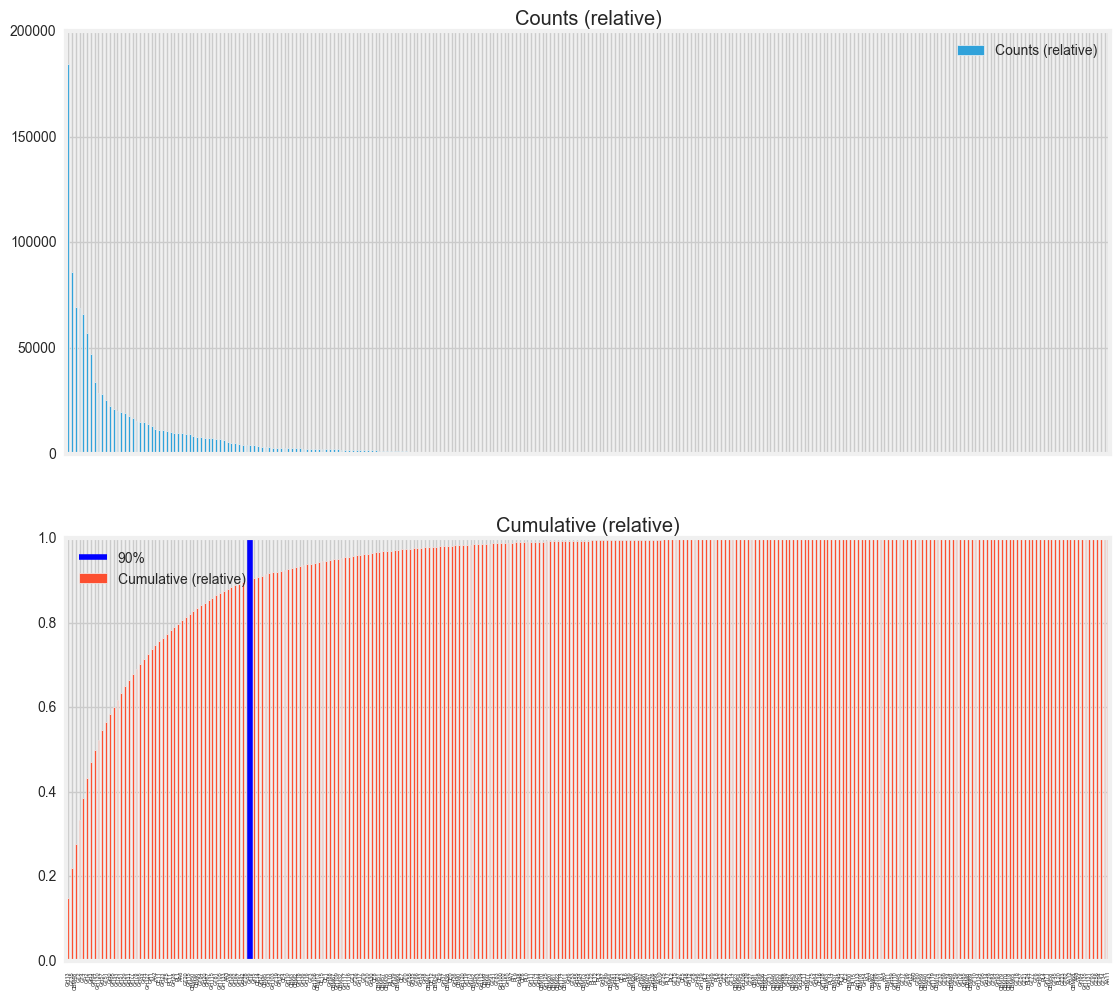

In [10]:
cumsum = pd.DataFrame(data={
                      'Counts (relative)': counts, 
                      'Cumulative (relative)': counts.cumsum() / counts.sum()
                    })
axes = cumsum.plot.bar(subplots=True,
                       figsize=(12, 12))
for ax in axes:
    ax.tick_params(axis='x', which='major', labelsize=4)
    
axes[1].axvline(bisect(cumsum['Cumulative (relative)'], .9),
                label="90%")
axes[1].legend(loc='best')

### Filtering families with more than 1% relative abundance

In [11]:
most_abundant = counts[(counts / counts.sum()) > .01]
most_abundant

GH13     184546
GT35      85969
CBM48     69274
GT2       69055
GT4       66086
GH2       57156
GH3       47404
GH94      34164
GH130     28600
GH57      28304
GT51      25288
GH0       22424
GH95      21383
GH43      20014
GH51      19561
GH29      19059
GH31      18056
GH77      16984
GH78      15401
GH65      15003
GH4       14975
GH127     14032
GH1       13273
Name: subject, dtype: int64

In [12]:
len(most_abundant)

23

In [13]:
abundances = pd.DataFrame({
        "Most abundant (absolute)": most_abundant,
        "Most abundant (relative)": most_abundant / counts.sum()})
abundances

,Most abundant (absolute),Most abundant (relative)
GH13,184546,0.150170
GT35,85969,0.069955
CBM48,69274,0.056370
GT2,69055,0.056192
GT4,66086,0.053776
GH2,57156,0.046509
GH3,47404,0.038574
GH94,34164,0.027800
GH130,28600,0.023273
GH57,28304,0.023032


The 23 families with more than 1% relative abundance account for 72% of the matches:

In [14]:
abundances['Most abundant (relative)'].sum(), len(abundances)

(0.73724404271732158, 23)

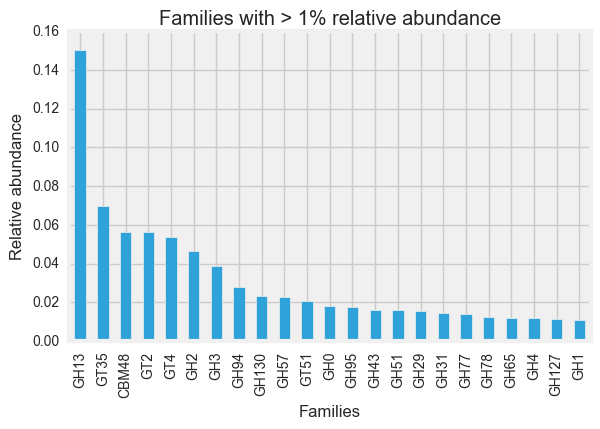

In [15]:
ax = abundances['Most abundant (relative)'].plot.bar()
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.set_title("Families with > 1% relative abundance")

## Analysis per depth

In [16]:
abundance = pd.DataFrame(abundances_per_depth)
abundance.sort_values(by=2, ascending=False, inplace=True)

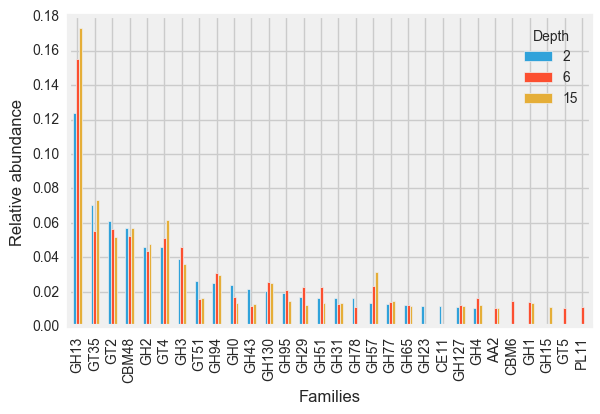

In [17]:
ax = abundance.plot.bar()
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.legend(loc='best', title="Depth")

Some families are abundant in some families but not in others (see families to the right),
so we have two approaches: 
  - Only use families with relative abundance > 1% in every depth,
  - select all families with relative abundance > 1% in any depth, even if it is less than that in other depths.

In [18]:
abundance

,2,6,15
GH13,0.123909,0.155231,0.172981
GT35,0.070255,0.055459,0.073539
GT2,0.060836,0.056628,0.051804
CBM48,0.056802,0.052278,0.057062
GH2,0.045872,0.043465,0.047906
GT4,0.045855,0.051296,0.061723
GH3,0.038930,0.045703,0.036348
GT51,0.026427,0.016083,0.016393
GH94,0.024974,0.031177,0.029501
GH0,0.023839,0.016771,0.013495


In [19]:
abundance.sum()

2     0.729161
6     0.791836
15    0.770102
dtype: float64

In [20]:
abundance.describe()

/home/chick/.virtualenvs/cazy/lib/python3.4/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,2,6,15
count,24.000000,27.000000,24.000000
mean,0.030382,0.029327,0.032088
std,0.026407,0.029530,0.035447
min,0.010703,0.010524,0.010339
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,0.123909,0.155231,0.172981


### Using only families with relative abundance >1% in every depth

In this case, we drop any family containing `NaN` (not a number) in our abundance dataframe.

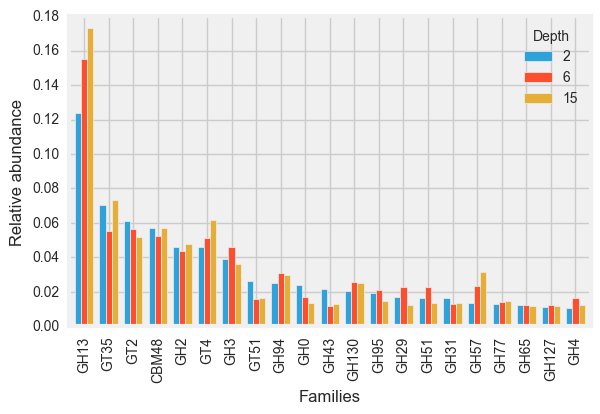

In [21]:
ax = abundance.dropna().plot.bar(width=.75)
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.legend(loc='best', title="Depth")

In [22]:
abundance.dropna()

,2,6,15
GH13,0.123909,0.155231,0.172981
GT35,0.070255,0.055459,0.073539
GT2,0.060836,0.056628,0.051804
CBM48,0.056802,0.052278,0.057062
GH2,0.045872,0.043465,0.047906
GT4,0.045855,0.051296,0.061723
GH3,0.038930,0.045703,0.036348
GT51,0.026427,0.016083,0.016393
GH94,0.024974,0.031177,0.029501
GH0,0.023839,0.016771,0.013495


In [23]:
abundance.sum()

2     0.729161
6     0.791836
15    0.770102
dtype: float64

In [24]:
abundance.dropna().describe()

,2,6,15
count,21.000000,21.000000,21.000000
mean,0.032837,0.034292,0.034983
std,0.027398,0.031881,0.037071
min,0.010703,0.011646,0.011640
25%,0.016327,0.016083,0.013349
50%,0.021536,0.022999,0.016393
75%,0.045855,0.045703,0.047906
max,0.123909,0.155231,0.172981


### Using families with relative abundance >1% in any depth

In [25]:
families_to_track = abundance.index

any_abundances_per_depth = {}

for depth in DEPTHS:
    counts = samples_per_depth[depth]['families'].value_counts()
    most_common = counts[families_to_track]

    any_abundances_per_depth[depth] = most_common / samples_per_depth[depth]['families'].count()

In [26]:
abundance = pd.DataFrame(any_abundances_per_depth)
abundance.sort_values(by=2, ascending=False, inplace=True)

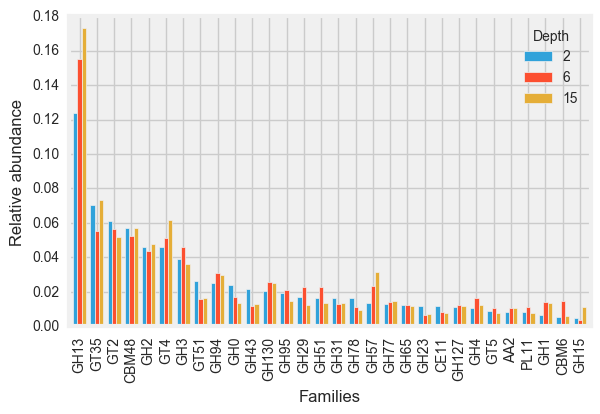

In [27]:
ax = abundance.dropna().plot.bar(width=.75)
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.legend(loc='best', title="Depth")

In [28]:
abundance

,2,6,15
GH13,0.123909,0.155231,0.172981
GT35,0.070255,0.055459,0.073539
GT2,0.060836,0.056628,0.051804
CBM48,0.056802,0.052278,0.057062
GH2,0.045872,0.043465,0.047906
GT4,0.045855,0.051296,0.061723
GH3,0.038930,0.045703,0.036348
GT51,0.026427,0.016083,0.016393
GH94,0.024974,0.031177,0.029501
GH0,0.023839,0.016771,0.013495


In [29]:
abundance.sum()

2     0.771087
6     0.810124
15    0.815927
dtype: float64

In [30]:
abundance.describe()

,2,6,15
count,30.000000,30.000000,30.000000
mean,0.025703,0.027004,0.027198
std,0.025381,0.028851,0.033102
min,0.004740,0.003829,0.005687
25%,0.011073,0.011807,0.011440
50%,0.016493,0.016293,0.013560
75%,0.026064,0.029826,0.031051
max,0.123909,0.155231,0.172981
